Libraries
=

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from keras.layers  import Input, Reshape, Conv2DTranspose, BatchNormalization, ReLU
import tensorflow as tf
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt




Noiser
=

In [2]:
def noiser(data, noise_factor=1.5):
    noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape).astype(np.float32)
    data = data + noise_factor * noise
    data = np.clip(data, 0., 1.)
    return data

Data Loader
=

In [3]:
def load_images(path):
    images = []
    count = 0  # Counter for folders
    for subdir, dirs, files in os.walk(path):
        if count >= 100:  # If 20 folders have been processed, break the loop
            break
        for file in files:
            file_path = os.path.join(subdir, file)
            image = Image.open(file_path)
            image = image.resize((64, 64))
            image = np.array(image) / 255.0  # Normalize pixel values
            images.append(image)
        count += 1  # Increment the counter when all files in a folder have been processed
    return np.array(images)


Load data
=

In [4]:
train_dir = 'D:/MO3 LAP/Datasets/Birds_525_Species/train'
test_dir = 'D:/MO3 LAP/Datasets/Birds_525_Species/test'  
val_dir = 'D:/MO3 LAP/Datasets/Birds_525_Species/valid'
train_images = load_images(train_dir)
test_images = load_images(test_dir)
val_images = load_images(val_dir)

Look at some shapes
=

In [5]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)


(15574, 64, 64, 3)
(495, 64, 64, 3)
(495, 64, 64, 3)


Add noise
=

In [6]:
noisy_train_images = np.array([noiser(img) for img in train_images])
noisy_test_images = np.array([noiser(img) for img in test_images])
noisy_val_images = np.array([noiser(img) for img in val_images])

Flatten images as feature vector to apply PCA on it
=

In [7]:
flattened__train_images = noisy_train_images.reshape(-1,64*64*3)
flattened__test_images = noisy_test_images.reshape(-1,64*64*3)
flattened__val_images = noisy_val_images.reshape(-1,64*64*3)

Appling PCA
= 

In [8]:
pca= PCA(n_components=2*2*64) 
pca_train_codes=pca.fit_transform(flattened__train_images)


In [9]:
pca2= PCA(n_components=2*2*64) 
pca_test_codes=pca2.fit_transform(flattened__test_images)

In [10]:
pca3= PCA(n_components=2*2*64) 
pca_val_codes=pca3.fit_transform(flattened__val_images)

Reshape PCA codes to fit in Decoders' conv layers
= 

In [11]:
pca_train_codes=pca_train_codes.reshape(-1,2,2,64)
pca_val_codes=pca_val_codes.reshape(-1,2,2,64)
pca_test_codes=pca_test_codes.reshape(-1,2,2,64)

pca_val_codes.shape

(495, 2, 2, 64)

Define Decoder
=

In [12]:
# Define deconvolutional block
def deconv_block(x, filters, kernel_size):
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def build_decoder(output_shape):
    inputs = Input(shape=output_shape)

   #x = deconv_block(inputs, 512, 3)  # Additional layer
    x = deconv_block(inputs, 256, 3)  # Additional layer
    x = deconv_block(x, 128, 3)
    x = deconv_block(x, 64, 3)
    x = deconv_block(x, 32, 3)
    x = deconv_block(x, 3, 3)  # 3 channels for RGB images

    return Model(inputs, x, name='decoder')

Build the Decoder
=

In [13]:
decoder = build_decoder((2,2,64)) 

Look at Decoder summary
=

In [14]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 2, 64)]        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        147712    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 256)        1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        295040    
 ranspose)                                                       
                                                           

Compile Decoder
=

In [15]:
decoder.compile(optimizer=Adam(learning_rate=0.009), loss=MeanSquaredLogarithmicError(),metrics='accuracy')


Smething for Graph Execution
=

In [ ]:
tf.config.experimental_run_functions_eagerly(True)


Fitting Decoder
=

In [17]:
decoder.fit(pca_train_codes, train_images, epochs=20, batch_size=32,validation_data=(pca_val_codes,val_images))

c:\ProgramData\anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20
487/487 [==============================] - 23s 39ms/step - loss: 0.0177 - accuracy: 0.3829 - val_loss: 0.0304 - val_accuracy: 0.3117
Epoch 2/20
487/487 [==============================] - 20s 41ms/step - loss: 0.0093 - accuracy: 0.5152 - val_loss: 0.0309 - val_accuracy: 0.4352
Epoch 3/20
487/487 [==============================] - 20s 42ms/step - loss: 0.0085 - accuracy: 0.5930 - val_loss: 0.0308 - val_accuracy: 0.4243
Epoch 4/20
487/487 [==============================] - 22s 45ms/step - loss: 0.0080 - accuracy: 0.6430 - val_loss: 0.0343 - val_accuracy: 0.4402
Epoch 5/20
487/487 [==============================] - 20s 40ms/step - loss: 0.0077 - accuracy: 0.6528 - val_loss: 0.0312 - val_accuracy: 0.4290
Epoch 6/20
487/487 [==============================] - 22s 45ms/step - loss: 0.0076 - accuracy: 0.6588 - val_loss: 0.0319 - val_accuracy: 0.4486
Epoch 7/20
487/487 [==============================] - 18s 36ms/step - loss: 0.0074 - accuracy: 0.6629 - val_loss: 0.0330 - val_accuracy:

Save Decoder
=

In [ ]:
decoder.save('D:/MO3 LAP/GAN/assignment 3/models/Noised_PCA_decoder.h5')  

Test Decoder
=

In [ ]:
image = train_images[1]
noised_image = noisy_train_images[1]
codes = pca_train_codes
decoded_images = decoder.predict(codes)

487/487 [==============================] - 5s 11ms/step


Plot Results
=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


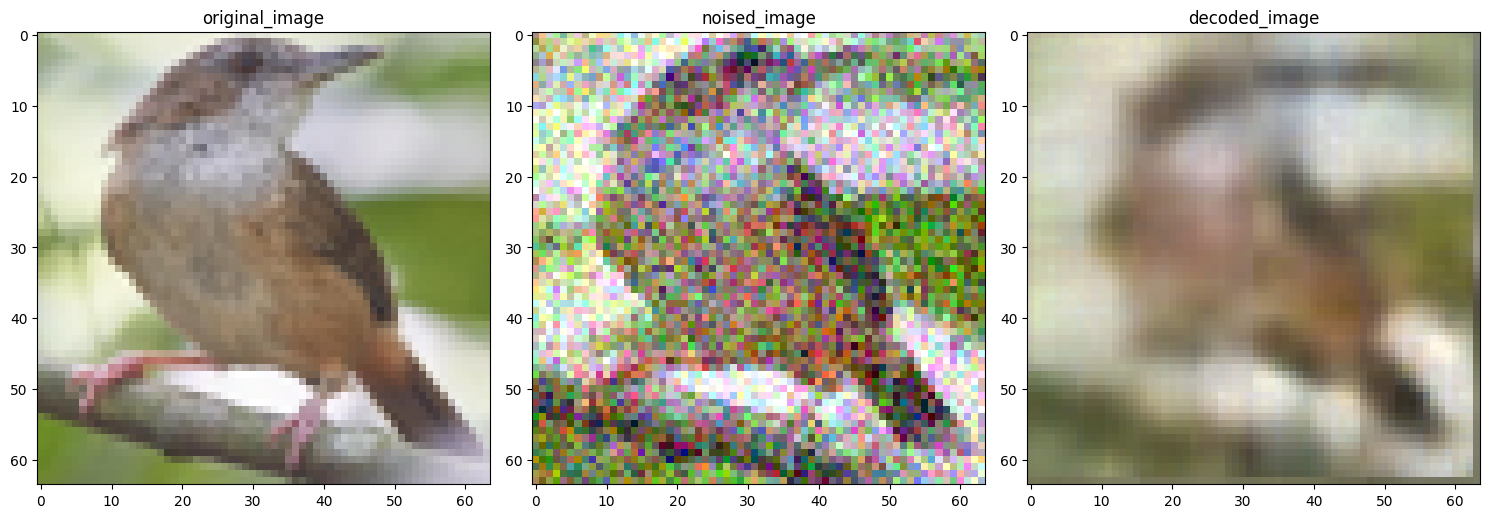

In [ ]:
# Set the figure size
plt.figure(figsize=(15, 5))  # Adjust the width and height as needed

# Plot the first image
plt.subplot(131)  # 1 row, 3 columns, first subplot
plt.imshow(image)
plt.title('original_image')

# Plot the second image
plt.subplot(132)  # 1 row, 3 columns, second subplot
plt.imshow(noised_image)
plt.title('noised_image')

# Plot the third image
plt.subplot(133)  # 1 row, 3 columns, third subplot
plt.imshow(decoded_images[1])
plt.title('decoded_image')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


-----
Report
==
* training accuracy == 66%, validation accuracy == 45% , thats low accuracy compared to the normal AutoEncoder model
* When visualizing results, our eyes can notice the difference.